## <font color=Green> Q1

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold

import xgboost as xgb
from matplotlib import pyplot
from scipy.stats import uniform, randint

# update jupyter kernel automatically
%load_ext autoreload
%autoreload 2

# show all columns/rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [192]:
# load dataset
df_train = pd.read_csv("../data/spenddata.csv", index_col=0).reset_index(drop=True)
# drop the original target variable as this is not our focus
df_train = df_train.drop(["t.158"], axis=1)
display(f"training data, size {df_train.shape}", df_train.head())

df_test = pd.read_csv("../data/testdata.csv", index_col=0).reset_index(drop=True)
df_test_backup = df_test.copy()
display(f"testing data, size {df_test.shape}:", df_test.head())

'training data, size (18379, 299)'

,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,t7.174,t7.175,t7.176,t7.177,t7.178,t7.179,t7.180,t7.181,t7.182,a.183,a.184,a.185,a.186,var2,totshopping.rep,var1,c.187,f.188,c.189,c.190,var0,var9,year,respondent.id,b.191,b.192,b.193,b.194,b.195,c.196,c.197,c.198,c.199,c.200,c.201,c.202,c.203,c.204,c.205,c.206,c.207,c.208,c.209,c.210,c.211,c.212,c.213,c.214,c.215,c.216,c.217,c.218,c.219,c.220,c.221,c.222,c.223,c.224,c.225,c.226,c.227,c.228,c.229,c.230,c.231,c.232,c.233,c.234,c.235,c.236,c.237,c.238,c.239,c.240,c.241,c.242,c.243,c.244,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284
0,1,2.0,NaN,1,5,1,57,34,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,6,6,6.0,6.0,7,0.0,0.0,14,1,0,0,0,0,0,0,1,1,1,1.0,1,1,0,0,NaN,NaN,2,679.04,0.0,0.0,0,0.0,0.0,0,0,679.04,2.0,0,0.0,0,400.0,0,0.0,0,0.0,400.0,50.0,50.0,2.0,NaN,0.0,2,0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,6,2,3,2,2,2,2,2.0,1,2,3,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.04,6004575.00,2.0,150.0,2,0.0,482.11,0.0,0.0,60.43,123.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,75.0,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,113.17,NaN,NaN,26.70,75.0,101.70,1,2,3,1.0,15.0,1,Mono,2016,2016_1,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,5.0
1,1,2.0,NaN,1,4,1,57,34,2,3.0,1,1.0,2,NaN,NaN,2,NaN,NaN,50,50,50.0,50.0,12,0.0,0.0,31,1,14,0,0,0,0,0,2,2,2,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0.0,0,0,0.00,NaN,0,100.0,0,30.0,0,0.0,0,0.0,130.0,100.0,100.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,5,2,2,2,3,3,2,2.0,2,1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.04,6004575.00,NaN,0.0,2,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,26.70,0.0,26.70,1,2,1,7.0,NaN,14,Mono,2016,2016_2,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN
2,1,2.0,NaN,1,5,1,57,42,2,1.0,1,1.0,1,93.0,1.0,1,93.0,60.0,6,6,6.0,6.0,7,0.0,0.0,45,1,31,0,0,0,0,0,2,2,3,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0.0,0,0,0.00,NaN,0,0.0,0,1000.0,0,0.0,0,0.0,1000.0,250.0,250.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,7,4,4,4,4,4,4,NaN,1,1,2,13.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.

'testing data, size (4595, 299):'

,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,t7.174,t7.175,t7.176,t7.177,t7.178,t7.179,t7.180,t7.181,t7.182,a.183,a.184,a.185,a.186,var2,totshopping.rep,var1,c.187,f.188,c.189,c.190,var0,var9,year,respondent.id,b.191,b.192,b.193,b.194,b.195,c.196,c.197,c.198,c.199,c.200,c.201,c.202,c.203,c.204,c.205,c.206,c.207,c.208,c.209,c.210,c.211,c.212,c.213,c.214,c.215,c.216,c.217,c.218,c.219,c.220,c.221,c.222,c.223,c.224,c.225,c.226,c.227,c.228,c.229,c.230,c.231,c.232,c.233,c.234,c.235,c.236,c.237,c.238,c.239,c.240,c.241,c.242,c.243,c.244,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284
0,1,1.0,NaN,1,11,1,47,8,2,1.0,1,1.0,1,211.0,0.0,1,211.0,NaN,12,12,12.0,12.0,10,0.0,0.0,31,NaN,14,0,0,0,0,0,2,2,2,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,NaN,0,0.0,0,300.0,0,0.0,0,0,300.0,50.0,50.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,NaN,0,7,2,2,2,2,2,2,2.0,2,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.26,997702.35,NaN,0.0,2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,8.51,0.0,NaN,1,2,1,7.0,NaN,14,NaN,2016,2016_9,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0
1,1,2.0,NaN,1,11,1,65,27,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,4,4,4.0,4.0,5,0.0,0.0,14,NaN,0,0,0,0,0,0,1,1,1,1.0,1,1,0,0,NaN,NaN,2,583.58,0.0,0.0,0,0.0,0,0.0,0,583.58,1.0,0,0.0,0,200.0,0,0.0,0,0,200.0,40.0,40.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,6,3,3,2,2,2,2,1.0,1,1,13,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,20.0,2,0.0,404.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,145.90,NaN,NaN,49.55,20.0,NaN,1,2,2,1.0,64.0,3,Mono,2016,2016_15,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0
2,1,2.0,NaN,1,6,1,65,27,2,1.0,1,1.0,2,NaN,NaN,2,NaN,NaN,56,56,56.0,56.0,12,0.0,0.0,45,NaN,0,0,0,0,0,0,2,2,3,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,1.0,0,700.0,0,250.0,0,0.0,0,0,950.0,300.0,300.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,7,4,4,4,4,4,4,NaN,1,2,2,14.0,8.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,60.0,2,0.0,0.00,0.0,0.0,0.0,0.0

In [158]:
# name target variable Y
target_name = "pov6"

In [159]:
# check distribution of target variable
df_train.loc[:, target_name].value_counts()

pov6
1    14197
2     3246
3      335
6      285
4      183
5      133
Name: count, dtype: int64

<font color="yellow"> Notice the Y is imbalance, we shall apply weights to each data example during training to tackle this problem

In [160]:
# check missing value for target in training
df_train.loc[:, target_name].isnull().any()

False

In [161]:
# check missing value for target in testing
df_test.loc[:, target_name].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: pov6, dtype: float64

<font color="yellow"> This problem can be considered as a multi-class single-label classification problem, we shall train a ML model based on training dataset, and predict the target variable in testing dataset.

In [162]:
# check missing values across each column
df_train.isnull().sum()

month                  0
var8                4009
var6               16480
a.1                    0
a.2                    0
a.3                    0
a.4                    0
var5                   0
b.5                    0
b.6                 8079
b.7                    0
b.8                 1773
b.9                    0
b.10               16007
b.11               16007
b.12                   0
b.13               11683
b.14               11920
b.15                   0
b.16                   0
b.17                   0
b.18                   0
b.19                   0
b.20               14234
b.21               15098
b.22                   0
pov6                   0
b.23                   0
b.24                   0
b.25                   0
b.26                   0
b.27                   0
b.28                   0
c.29                   0
c.30                   0
var7                   0
c.31               15225
c.32                   0
c.33                   0
c.34                   0


<font color="yellow"> Noted that there are quite a number of missing values in the predictor variables as well. We have a few methods to tackle missing values, e.g. impute with KNN, impute with mean/median, however, in this problem, the No. of missing values are quite huge, we can try the built in method from XGBoost later during modelling.

In [163]:
# check data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18379 entries, 0 to 18378
Columns: 299 entries, month to f.284
dtypes: float64(133), int64(164), object(2)
memory usage: 41.9+ MB


<font color="yellow"> Most of the predictors are numeric, however, there are two object variables, which means they are categorical. We need to find them and encode them into numeric so that they can be understood by model.

In [164]:
# get categorical variables
for colname, type_ in df_train.dtypes.items():
    if type_ == "object":
        print(colname)

var9
respondent.id


In [165]:
# get the two categorical variables
df_train.loc[:, ["var9", "respondent.id"]].head()

,var9,respondent.id
0,Mono,2016_1
1,Mono,2016_2
2,Multi,2016_3
3,Mono,2016_4
4,Multi,2016_5


In [166]:
# look into the first categorical variable
display("from training data:", df_train["respondent.id"].apply(lambda x: x.replace("2016_", "")).head(5))

display("from testing data:", df_test["respondent.id"].apply(lambda x: x.replace("2016_", "")).head(5))

'from training data:'

0    1
1    2
2    3
3    4
4    5
Name: respondent.id, dtype: object

'from testing data:'

0     9
1    15
2    16
3    24
4    32
Name: respondent.id, dtype: object

<font color="red"> Assumption: we assume it's customer index as this variable looks like customer index + year, and will drop it from the dataframe

In [167]:
# # store customer_id for training data
# customer_id_train = df_train[["respondent.id"]]
# display(customer_id_train.head())

# # store customer_id for testing data
# customer_id_test = df_test[["respondent.id"]]
# display(customer_id_test.head())


In [168]:
# drop the customer_id
df_train = df_train.drop(["respondent.id"], axis=1)
df_test = df_test.drop(["respondent.id"], axis=1)

In [169]:
# apply onehotencoding for categorical variables
enc = OneHotEncoder(handle_unknown='error', sparse_output=False, drop=None)

feature_arr = enc.fit_transform(df_train[["var9"]])
feature_labels = enc.get_feature_names_out()

# for training data
cat_train = pd.DataFrame(feature_arr, columns=feature_labels).reset_index(drop=True)
df_train = pd.concat([df_train.drop(["var9"], axis=1).reset_index(drop=True), cat_train], axis=1)
display("training data after encoding:", df_train.head())

# for testing data
cat_test = pd.DataFrame(enc.transform(df_test[["var9"]]), columns=feature_labels).reset_index(drop=True)

df_test = pd.concat([df_test.drop(["var9"], axis=1).reset_index(drop=True), cat_test], axis=1)
display("testing data after encoding:", df_test.head())

'training data after encoding:'

,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,t7.174,t7.175,t7.176,t7.177,t7.178,t7.179,t7.180,t7.181,t7.182,a.183,a.184,a.185,a.186,var2,totshopping.rep,var1,c.187,f.188,c.189,c.190,var0,year,b.191,b.192,b.193,b.194,b.195,c.196,c.197,c.198,c.199,c.200,c.201,c.202,c.203,c.204,c.205,c.206,c.207,c.208,c.209,c.210,c.211,c.212,c.213,c.214,c.215,c.216,c.217,c.218,c.219,c.220,c.221,c.222,c.223,c.224,c.225,c.226,c.227,c.228,c.229,c.230,c.231,c.232,c.233,c.234,c.235,c.236,c.237,c.238,c.239,c.240,c.241,c.242,c.243,c.244,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284,var9_Mono,var9_Multi,var9_nan
0,1,2.0,NaN,1,5,1,57,34,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,6,6,6.0,6.0,7,0.0,0.0,14,1,0,0,0,0,0,0,1,1,1,1.0,1,1,0,0,NaN,NaN,2,679.04,0.0,0.0,0,0.0,0.0,0,0,679.04,2.0,0,0.0,0,400.0,0,0.0,0,0.0,400.0,50.0,50.0,2.0,NaN,0.0,2,0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,6,2,3,2,2,2,2,2.0,1,2,3,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.04,6004575.00,2.0,150.0,2,0.0,482.11,0.0,0.0,60.43,123.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,75.0,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,113.17,NaN,NaN,26.70,75.0,101.70,1,2,3,1.0,15.0,1,2016,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,5.0,1.0,0.0,0.0
1,1,2.0,NaN,1,4,1,57,34,2,3.0,1,1.0,2,NaN,NaN,2,NaN,NaN,50,50,50.0,50.0,12,0.0,0.0,31,1,14,0,0,0,0,0,2,2,2,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0.0,0,0,0.00,NaN,0,100.0,0,30.0,0,0.0,0,0.0,130.0,100.0,100.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,5,2,2,2,3,3,2,2.0,2,1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.04,6004575.00,NaN,0.0,2,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,26.70,0.0,26.70,1,2,1,7.0,NaN,14,2016,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,1.0,0.0,0.0
2,1,2.0,NaN,1,5,1,57,42,2,1.0,1,1.0,1,93.0,1.0,1,93.0,60.0,6,6,6.0,6.0,7,0.0,0.0,45,1,31,0,0,0,0,0,2,2,3,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0.0,0,0,0.00,NaN,0,0.0,0,1000.0,0,0.0,0,0.0,1000.0,250.0,250.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,7,4,4,4,4,4,4,NaN,1,1,2,13.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

'testing data after encoding:'

,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,pov6,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,t7.174,t7.175,t7.176,t7.177,t7.178,t7.179,t7.180,t7.181,t7.182,a.183,a.184,a.185,a.186,var2,totshopping.rep,var1,c.187,f.188,c.189,c.190,var0,year,b.191,b.192,b.193,b.194,b.195,c.196,c.197,c.198,c.199,c.200,c.201,c.202,c.203,c.204,c.205,c.206,c.207,c.208,c.209,c.210,c.211,c.212,c.213,c.214,c.215,c.216,c.217,c.218,c.219,c.220,c.221,c.222,c.223,c.224,c.225,c.226,c.227,c.228,c.229,c.230,c.231,c.232,c.233,c.234,c.235,c.236,c.237,c.238,c.239,c.240,c.241,c.242,c.243,c.244,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284,var9_Mono,var9_Multi,var9_nan
0,1,1.0,NaN,1,11,1,47,8,2,1.0,1,1.0,1,211.0,0.0,1,211.0,NaN,12,12,12.0,12.0,10,0.0,0.0,31,NaN,14,0,0,0,0,0,2,2,2,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,NaN,0,0.0,0,300.0,0,0.0,0,0,300.0,50.0,50.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,NaN,0,7,2,2,2,2,2,2,2.0,2,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.26,997702.35,NaN,0.0,2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,8.51,0.0,NaN,1,2,1,7.0,NaN,14,2016,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,0.0,0.0,1.0
1,1,2.0,NaN,1,11,1,65,27,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,4,4,4.0,4.0,5,0.0,0.0,14,NaN,0,0,0,0,0,0,1,1,1,1.0,1,1,0,0,NaN,NaN,2,583.58,0.0,0.0,0,0.0,0,0.0,0,583.58,1.0,0,0.0,0,200.0,0,0.0,0,0,200.0,40.0,40.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,6,3,3,2,2,2,2,1.0,1,1,13,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,20.0,2,0.0,404.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,145.90,NaN,NaN,49.55,20.0,NaN,1,2,2,1.0,64.0,3,2016,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0,1.0,0.0,0.0
2,1,2.0,NaN,1,6,1,65,27,2,1.0,1,1.0,2,NaN,NaN,2,NaN,NaN,56,56,56.0,56.0,12,0.0,0.0,45,NaN,0,0,0,0,0,0,2,2,3,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,1.0,0,700.0,0,250.0,0,0.0,0,0,950.0,300.0,300.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,7,4,4,4,4,4,4,NaN,1,2,2,14.0,8.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,60.0,2,0.0,0.00,0.0,

In [170]:
# label encoding for target variable
le = preprocessing.LabelEncoder()
le.fit_transform(df_train[target_name])

Y_train = pd.DataFrame(le.fit_transform(df_train[target_name]), columns=["Y"])

df_train.drop([target_name], axis=1, inplace=True)
df_test.drop([target_name], axis=1, inplace=True)

In [172]:
# train, val, test split
X_train, X, y_train, y = train_test_split(df_train, Y_train, test_size=0.3, random_state=1, shuffle=True, stratify=Y_train)
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True, stratify=y)

print(f"train set size: {X_train.shape}, \nval set size: {X_val.shape}, \ntest set size: {X_test.shape}")

train set size: (12865, 299), 
val set size: (1655, 299), 
test set size: (3859, 299)


In [173]:
# impute missing predictor values with np.nan, so that XGBoost will handle them
X_train = X_train.fillna(np.nan)
X_test = X_test.fillna(np.nan)
X_val = X_val.fillna(np.nan)

df_train = df_train.fillna(np.nan)
df_test = df_test.fillna(np.nan)

<font color="red"> Assumption: To apply modelling, we assume the training data and test data are i.i.d, and there are strong correlation between predictors and target variable.

<font color="yellow"> Before finetuning, we leverage random search to search for best set of hyperparameters.

In [27]:
# calculate sample weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Finetune Hyperparameters
params = {
    "colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7],
    "gamma": uniform(0, 0.5),
    "max_depth": [3, 4, 5, 6, 7],
    "n_estimators": randint(30, 150),
    "subsample": [0.4, 0.5, 0.6, 0.7],
    "min_child_weight": [0.5, 1, 2, 3],
    "eta": [0.3, 0.1, 0.03, 0.005, 0.001],
}

k = StratifiedKFold(n_splits=3, shuffle=False)
scoring="f1_weighted"

cv_model = xgb.XGBClassifier(
    objective = "multi:softmax",
    num_class = y_train.nunique(),
    n_estimators = 100,
    tree_method= "auto",
    booster = "gbtree")

search = RandomizedSearchCV(
    cv_model,
    param_distributions=params,
    scoring=scoring,
    random_state=1,
    n_iter=100,  # No. of combinations
    cv=k,
    verbose=1,
    n_jobs=1,
    return_train_score=True,
    refit=False,  # refit by manual as we need to plot the train-val curve to see overfitting problem
    )

search.fit(X_train, y_train, sample_weight=sample_weights)
cv_results =  pd.DataFrame(search.cv_results_).loc[:, ["rank_test_score", "mean_test_score", "params"]].sort_values(by=["rank_test_score"])
cv_results.head(5)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,rank_test_score,mean_test_score,params
12,1,0.966812,"{'colsample_bytree': 0.5, 'eta': 0.3, 'gamma':..."
97,2,0.966101,"{'colsample_bytree': 0.7, 'eta': 0.3, 'gamma':..."
62,3,0.965924,"{'colsample_bytree': 0.7, 'eta': 0.1, 'gamma':..."
84,4,0.965779,"{'colsample_bytree': 0.5, 'eta': 0.3, 'gamma':..."
68,5,0.965519,"{'colsample_bytree': 0.3, 'eta': 0.3, 'gamma':..."


In [174]:
# show the best set of hyperparams
search.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.3,
 'gamma': 0.05116721441391292,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 107,
 'subsample': 0.7}

<font color="yellow"> Based on the best set, we can manually fill up them in the actual finetuning

In [176]:
# calculate sample weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# parameters
objective = "multi:softmax"
num_class = y_train.nunique()
n_estimators = 200
early_stopping_rounds = 5
tree_method= "auto"
# booster = "dart"
booster = "gbtree"
eval_metric="mlogloss"

# tuning parameters
eta = 0.3
max_depth = 4
max_leaves = 2**max_depth

# prevent overfitting
min_child_weight = 1
gamma = 0.051
subsample = 0.7
colsample_bytree = 0.5


# Use "hist" for constructing the trees, with early stopping enabled.
model = xgb.XGBClassifier(
    early_stopping_rounds=early_stopping_rounds,
    tree_method=tree_method,
    num_class=num_class,
    objective=objective,
    n_estimators=n_estimators,
    missing=np.nan,
    eval_metric=eval_metric,
    booster=booster,
    eta=eta,
    max_depth=max_depth,
    max_leaves=max_leaves,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree)


# Fit the model, val sets are used for early stopping.
result = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight=sample_weights, verbose=True)

[0]	validation_0-mlogloss:1.29709	validation_1-mlogloss:1.29678
[1]	validation_0-mlogloss:1.01553	validation_1-mlogloss:1.01688
[2]	validation_0-mlogloss:0.83051	validation_1-mlogloss:0.83471
[3]	validation_0-mlogloss:0.66817	validation_1-mlogloss:0.67477
[4]	validation_0-mlogloss:0.57899	validation_1-mlogloss:0.58585
[5]	validation_0-mlogloss:0.49302	validation_1-mlogloss:0.50058
[6]	validation_0-mlogloss:0.43289	validation_1-mlogloss:0.44076
[7]	validation_0-mlogloss:0.38477	validation_1-mlogloss:0.39352
[8]	validation_0-mlogloss:0.34499	validation_1-mlogloss:0.35330
[9]	validation_0-mlogloss:0.31708	validation_1-mlogloss:0.32723
[10]	validation_0-mlogloss:0.29253	validation_1-mlogloss:0.30452
[11]	validation_0-mlogloss:0.27476	validation_1-mlogloss:0.28737
[12]	validation_0-mlogloss:0.25807	validation_1-mlogloss:0.27154
[13]	validation_0-mlogloss:0.24186	validation_1-mlogloss:0.25606
[14]	validation_0-mlogloss:0.22722	validation_1-mlogloss:0.24277
[15]	validation_0-mlogloss:0.21320	

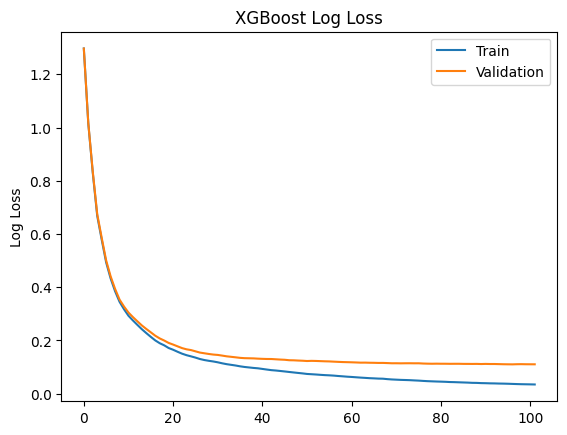

In [177]:
# check overfitting
results = result.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

In [178]:
# predict on validation set
preds = model.predict(X_val)

# 0.9653712962122963
f1_score(y_val, preds, average='weighted')

0.9667863069079635

In [179]:
# predict on test set
preds = model.predict(X_test)

# 0.9660171338493136
f1_score(y_test, preds, average='weighted')

0.9637437704043689

In [180]:
# calculate sample weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=Y_train
)

# parameters
objective = "multi:softmax"
num_class = y_train.nunique()
n_estimators = 100
tree_method= "auto"
# booster = "dart"
booster = "gbtree"

# tuning parameters
eta = 0.3
max_depth = 4
max_leaves = 2**max_depth

# prevent overfitting
min_child_weight = 1
gamma = 0.051
subsample = 0.7
colsample_bytree = 0.5


# Use "hist" for constructing the trees, with early stopping enabled.
model = xgb.XGBClassifier(
    tree_method=tree_method,
    num_class=num_class,
    objective=objective,
    n_estimators=n_estimators,
    missing=np.nan,
    booster=booster,
    eta=eta,
    max_depth=max_depth,
    max_leaves=max_leaves,
    min_child_weight=min_child_weight,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree)


# Fit the model, val sets are used for early stopping.
model.fit(df_train, Y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.051, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=16, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=Y    6
dtype: int64, ...)

In [181]:
# check if the model has been updated
f1_score(y_test, preds, average='weighted')

0.9637437704043689

In [184]:
# predict on the actual test set
preds = model.predict(df_test)
preds

array([0, 0, 3, ..., 0, 1, 0], dtype=int32)

In [185]:
# revert the labels back to original labels
preds = pd.DataFrame(le.inverse_transform(preds), columns=[target_name])
preds.head()

,pov6
0,1
1,1
2,4
3,1
4,1


In [193]:
# prepare original test data without target variable
df_test_backup = df_test_backup.drop([target_name], axis=1)
df_test_backup.head()

,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,t7.174,t7.175,t7.176,t7.177,t7.178,t7.179,t7.180,t7.181,t7.182,a.183,a.184,a.185,a.186,var2,totshopping.rep,var1,c.187,f.188,c.189,c.190,var0,var9,year,respondent.id,b.191,b.192,b.193,b.194,b.195,c.196,c.197,c.198,c.199,c.200,c.201,c.202,c.203,c.204,c.205,c.206,c.207,c.208,c.209,c.210,c.211,c.212,c.213,c.214,c.215,c.216,c.217,c.218,c.219,c.220,c.221,c.222,c.223,c.224,c.225,c.226,c.227,c.228,c.229,c.230,c.231,c.232,c.233,c.234,c.235,c.236,c.237,c.238,c.239,c.240,c.241,c.242,c.243,c.244,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284
0,1,1.0,NaN,1,11,1,47,8,2,1.0,1,1.0,1,211.0,0.0,1,211.0,NaN,12,12,12.0,12.0,10,0.0,0.0,31,14,0,0,0,0,0,2,2,2,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,NaN,0,0.0,0,300.0,0,0.0,0,0,300.0,50.0,50.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,NaN,0,7,2,2,2,2,2,2,2.0,2,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.26,997702.35,NaN,0.0,2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,8.51,0.0,NaN,1,2,1,7.0,NaN,14,NaN,2016,2016_9,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0
1,1,2.0,NaN,1,11,1,65,27,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,4,4,4.0,4.0,5,0.0,0.0,14,0,0,0,0,0,0,1,1,1,1.0,1,1,0,0,NaN,NaN,2,583.58,0.0,0.0,0,0.0,0,0.0,0,583.58,1.0,0,0.0,0,200.0,0,0.0,0,0,200.0,40.0,40.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,6,3,3,2,2,2,2,1.0,1,1,13,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,20.0,2,0.0,404.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,145.90,NaN,NaN,49.55,20.0,NaN,1,2,2,1.0,64.0,3,Mono,2016,2016_15,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0
2,1,2.0,NaN,1,6,1,65,27,2,1.0,1,1.0,2,NaN,NaN,2,NaN,NaN,56,56,56.0,56.0,12,0.0,0.0,45,0,0,0,0,0,0,2,2,3,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,1.0,0,700.0,0,250.0,0,0.0,0,0,950.0,300.0,300.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,7,4,4,4,4,4,4,NaN,1,2,2,14.0,8.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,60.0,2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [194]:
# final output
df_test = pd.concat([df_test_backup, preds], axis=1)
df_test.head()

,month,var8,var6,a.1,a.2,a.3,a.4,var5,b.5,b.6,b.7,b.8,b.9,b.10,b.11,b.12,b.13,b.14,b.15,b.16,b.17,b.18,b.19,b.20,b.21,b.22,b.23,b.24,b.25,b.26,b.27,b.28,c.29,c.30,var7,c.31,c.32,c.33,c.34,c.35,c.36,c.37,c.38,c.39,c.40,c.41,c.42,c.43,c.44,c.45,c.46,c.47,c.48,c.49,c.50,c.51,c.52,c.53,c.54,c.55,c.56,c.57,c.58,c.59,c.60,c.61,c.62,b.63,c.64,c.65,c.66,c.67,c.68,c.69,c.70,c.71,c.72,c.73,c.74,c.75,c.76,c.77,c.78,c.79,c.80,c.81,c.82,c.83,c.84,c.85,c.86,c.87,c.88,c.89,c.90,c.91,c.92,c.93,d.94,e.95,e.96,e.97,e.98,e.99,e.100,e.101,f.102,f.103,f.104,f.105,f.106,f.107,f.108,f.109,f.110,f.111,f.112,f.113,f.114,f.115,f.116,f.117,f.118,f.119,f.120,f.121,f.122,f.123,a.124,var3,var4,c.125,c.126,c.127,pp.128,pp.129,pp.130,pp.131,pp.132,pp.133,pp.134,c.135,c.136,c.137,c.138,c.139,c.140,c.141,c.142,c.143,c.144,c.145,c.146,c.147,c.148,t7.149,t7.150,t7.151,t7.152,t7.153,t7.154,t7.155,t7.156,t7.157,t7.158,c.159,c.160,c.161,c.162,c.163,c.164,c.165,c.166,c.167,c.168,c.169,c.170,c.171,c.172,t7.173,t7.174,t7.175,t7.176,t7.177,t7.178,t7.179,t7.180,t7.181,t7.182,a.183,a.184,a.185,a.186,var2,totshopping.rep,var1,c.187,f.188,c.189,c.190,var0,var9,year,respondent.id,b.191,b.192,b.193,b.194,b.195,c.196,c.197,c.198,c.199,c.200,c.201,c.202,c.203,c.204,c.205,c.206,c.207,c.208,c.209,c.210,c.211,c.212,c.213,c.214,c.215,c.216,c.217,c.218,c.219,c.220,c.221,c.222,c.223,c.224,c.225,c.226,c.227,c.228,c.229,c.230,c.231,c.232,c.233,c.234,c.235,c.236,c.237,c.238,c.239,c.240,c.241,c.242,c.243,c.244,c.245,c.246,c.247,c.248,c.249,c.250,c.251,c.252,c.253,c.254,c.255,c.256,c.257,c.258,c.259,c.260,c.261,c.262,c.263,c.264,c.265,c.266,c.267,c.268,c.269,c.270,c.271,c.272,c.273,c.274,c.275,c.276,c.277,c.278,c.279,c.280,c.281,c.282,c.283,f.284,pov6
0,1,1.0,NaN,1,11,1,47,8,2,1.0,1,1.0,1,211.0,0.0,1,211.0,NaN,12,12,12.0,12.0,10,0.0,0.0,31,14,0,0,0,0,0,2,2,2,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,NaN,0,0.0,0,300.0,0,0.0,0,0,300.0,50.0,50.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,NaN,0,7,2,2,2,2,2,2,2.0,2,2,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.26,997702.35,NaN,0.0,2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,8.51,0.0,NaN,1,2,1,7.0,NaN,14,NaN,2016,2016_9,0,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,3.0,1
1,1,2.0,NaN,1,11,1,65,27,1,NaN,1,1.0,2,NaN,NaN,2,NaN,NaN,4,4,4.0,4.0,5,0.0,0.0,14,0,0,0,0,0,0,1,1,1,1.0,1,1,0,0,NaN,NaN,2,583.58,0.0,0.0,0,0.0,0,0.0,0,583.58,1.0,0,0.0,0,200.0,0,0.0,0,0,200.0,40.0,40.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,6,3,3,2,2,2,2,1.0,1,1,13,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,20.0,2,0.0,404.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,145.90,NaN,NaN,49.55,20.0,NaN,1,2,2,1.0,64.0,3,Mono,2016,2016_15,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0,1
2,1,2.0,NaN,1,6,1,65,27,2,1.0,1,1.0,2,NaN,NaN,2,NaN,NaN,56,56,56.0,56.0,12,0.0,0.0,45,0,0,0,0,0,0,2,2,3,NaN,2,0,0,0,NaN,NaN,2,NaN,0.0,0.0,0,0.0,0,0.0,0,0.00,1.0,0,700.0,0,250.0,0,0.0,0,0,950.0,300.0,300.0,1.0,NaN,0.0,2,0,0.0,0.0,NaN,0.0,0,0,0,0,0,0,0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,2,7,4,4,4,4,4,4,NaN,1,2,2,14.0,8.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.69,10259011.96,1.0,60.0,2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0

In [195]:
df_test.shape

(4595, 299)